In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing import image


In [ ]:
versi_model = "model2-1-93-86"
MODEL_PATH = f"../models/{versi_model}/model2.h5"
NEW_IMAGES_DIR = "../dataset/public/alur/"
LABELS_PATH = f"../models/{versi_model}/labels.json"

# Load model
model = tf.keras.models.load_model(MODEL_PATH)

# Baca file labels.json
with open(LABELS_PATH, "r") as f:
    labels = json.load(f)

# Ambil daftar kelas (urut sesuai key int di json)
classes = [labels[str(i)] for i in range(len(labels))]
print("Kelas:", classes)


Kelas: ['alur', 'lubang', 'retak', 'tidak_rusak']


In [3]:
"""

# Loop setiap gambar baru
for img_name in os.listdir(NEW_IMAGES_DIR):
    img_path = os.path.join(NEW_IMAGES_DIR, img_name)
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Preprocess
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    
    # Prediksi
    pred = model.predict(x)[0]
    
    # Urutkan hasil dari yang terbesar
    sorted_idx = np.argsort(pred)[::-1]  # urutan descending
    sorted_classes = [(classes[i], pred[i] * 100) for i in sorted_idx]
    
    # Print hasil lengkap
    print(f"\n📷 {img_name}")
    for cls, conf in sorted_classes:
        print(f"   {cls:<15}: {conf:.2f}%")
    
    # Tampilkan gambar dengan label teratas
    top_class, top_conf = sorted_classes[0]
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"{top_class} ({top_conf:.2f}%)")
    plt.axis('off')
    plt.show()

"""


'\n\n# Loop setiap gambar baru\nfor img_name in os.listdir(NEW_IMAGES_DIR):\n    img_path = os.path.join(NEW_IMAGES_DIR, img_name)\n    img = image.load_img(img_path, target_size=(224, 224))\n    \n    # Preprocess\n    x = image.img_to_array(img) / 255.0\n    x = np.expand_dims(x, axis=0)\n    \n    # Prediksi\n    pred = model.predict(x)[0]\n    \n    # Urutkan hasil dari yang terbesar\n    sorted_idx = np.argsort(pred)[::-1]  # urutan descending\n    sorted_classes = [(classes[i], pred[i] * 100) for i in sorted_idx]\n    \n    # Print hasil lengkap\n    print(f"\n📷 {img_name}")\n    for cls, conf in sorted_classes:\n        print(f"   {cls:<15}: {conf:.2f}%")\n    \n    # Tampilkan gambar dengan label teratas\n    top_class, top_conf = sorted_classes[0]\n    plt.figure(figsize=(4, 4))\n    plt.imshow(img)\n    plt.title(f"{top_class} ({top_conf:.2f}%)")\n    plt.axis(\'off\')\n    plt.show()\n\n'

Last Conv2D layer: Conv_1


e:\Coding\miniconda3\envs\env_roadmodel\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


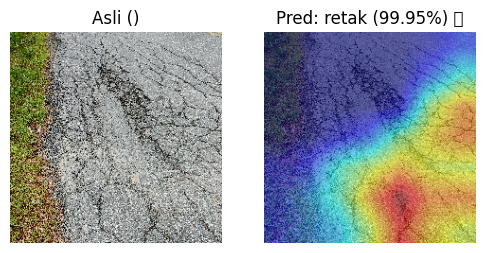

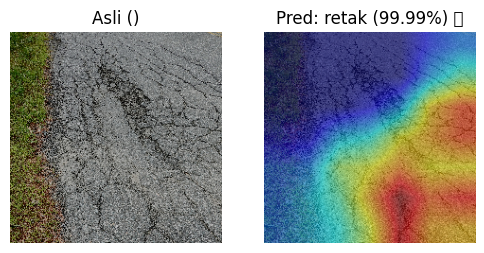

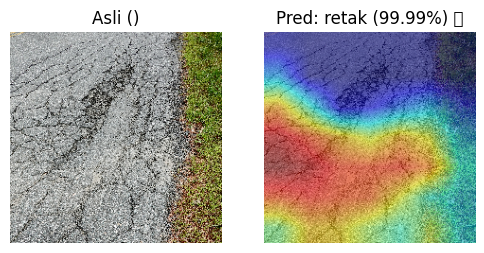

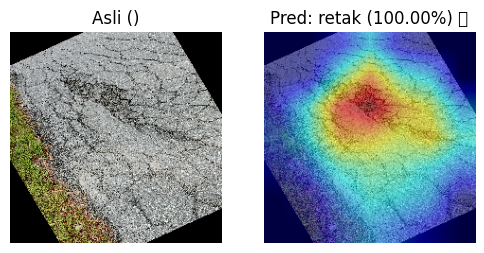

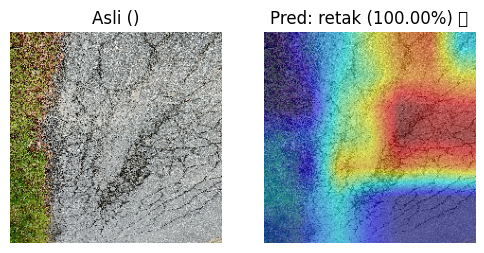

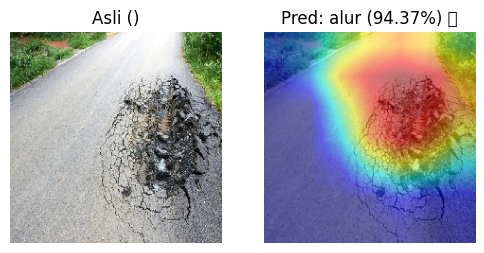

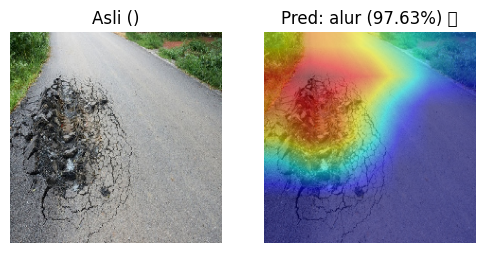

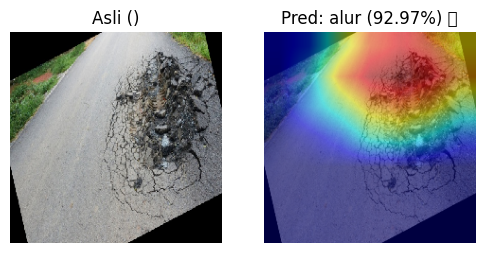

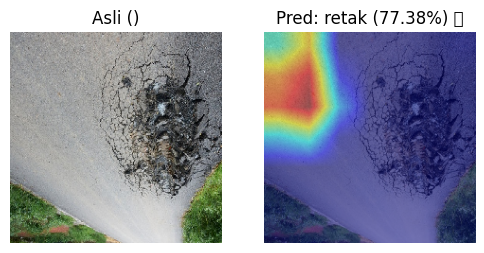

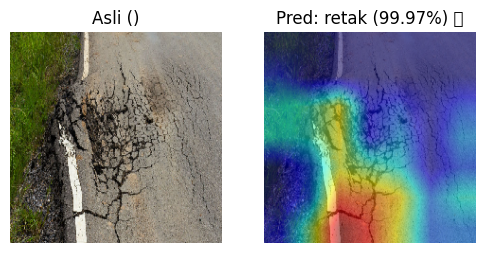


📊 Rangkuman gambar yang salah prediksi:
- 525.jpg: True=, Pred=retak (99.95%)
- 525_aug_brightness_contrast.jpg: True=, Pred=retak (99.99%)
- 525_aug_flip.jpg: True=, Pred=retak (99.99%)
- 525_aug_rotate.jpg: True=, Pred=retak (100.00%)
- 525_aug_vertical_flip.jpg: True=, Pred=retak (100.00%)
- 539_aug_brightness_contrast.jpg: True=, Pred=alur (94.37%)
- 539_aug_flip.jpg: True=, Pred=alur (97.63%)
- 539_aug_rotate.jpg: True=, Pred=alur (92.97%)
- 539_aug_vertical_flip.jpg: True=, Pred=retak (77.38%)
- 78.jpg: True=, Pred=retak (99.97%)


In [4]:
# ==========================================
# Fungsi Grad-CAM
# ==========================================
def grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# ==========================================
# Cari layer Conv2D terakhir
# ==========================================
last_conv_layer = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer = layer.name
        break
print("Last Conv2D layer:", last_conv_layer)

# ==========================================
# Loop semua gambar
# ==========================================
wrong_preds = []  # untuk menyimpan data gambar yang salah

for root, dirs, files in os.walk(NEW_IMAGES_DIR):  # supaya bisa baca semua subfolder
    for img_name in files:
        if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
            continue
        
        img_path = os.path.join(root, img_name)
        
        # Ambil label asli dari nama folder
        true_label = os.path.basename(root)

        # Preprocessing
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        x = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        x = np.expand_dims(x, axis=0)

        # Prediksi
        pred = model.predict(x, verbose=0)[0]
        class_idx = np.argmax(pred)
        top_class = classes[class_idx]
        conf = pred[class_idx] * 100

        # Cek apakah salah prediksi
        if top_class != true_label:
            wrong_preds.append((img_name, true_label, top_class, conf))

            # Grad-CAM
            heatmap = grad_cam(model, x, last_conv_layer)
            img_cv = cv2.imread(img_path)
            img_cv = cv2.resize(img_cv, (224, 224))
            heatmap = cv2.resize(heatmap, (224, 224))
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            superimposed_img = cv2.addWeighted(heatmap, 0.5, img_cv, 0.5, 0)

            # Tampilkan hasil yang salah
            plt.figure(figsize=(6, 3))
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title(f"Asli ({true_label})")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Pred: {top_class} ({conf:.2f}%) ❌")
            plt.axis('off')
            plt.show()

# ==========================================
# Tampilkan rekap hasil salah prediksi
# ==========================================
print("\n📊 Rangkuman gambar yang salah prediksi:")
for name, true_label, pred_label, conf in wrong_preds:
    print(f"- {name}: True={true_label}, Pred={pred_label} ({conf:.2f}%)")


In [5]:
from collections import Counter
import pandas as pd

# ==========================================
# Simpan semua label & prediksi
# ==========================================
y_true_all = []
y_pred_all = []

for root, dirs, files in os.walk(NEW_IMAGES_DIR):
    for img_name in files:
        if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        img_path = os.path.join(root, img_name)
        true_label = os.path.basename(root)

        # Preprocessing
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        x = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        x = np.expand_dims(x, axis=0)

        # Prediksi
        pred = model.predict(x, verbose=0)[0]
        top_class = classes[np.argmax(pred)]

        # Simpan
        y_true_all.append(true_label)
        y_pred_all.append(top_class)

# ==========================================
# Hitung jumlah per kelas
# ==========================================
true_counts = Counter(y_true_all)
pred_counts = Counter(y_pred_all)

# Gabungkan semua kelas yang muncul di label/prediksi
all_labels = sorted(set(list(true_counts.keys()) + list(pred_counts.keys())))

rekap = pd.DataFrame({
    "Kelas": all_labels,
    "Jumlah (hasil prediksi)": [pred_counts[k] for k in all_labels]
})

# ==========================================
# Tampilkan hasil
# ==========================================
print("\n📊 Rekap jumlah per kelas:")
rekap





📊 Rekap jumlah per kelas:


,Kelas,Jumlah (hasil prediksi)
0,,0
1,alur,3
2,retak,7
